# Acoustic Reverse Time Migration (RTM) with Variable Density

In this tutorial, we perform a RTM using forward and adjoint modeling equations. These equations are based on the squared slowness and the density of the medium.

## Forward modeling

The propagation of seismic waves in heterogeneous, isotropic, elastic earth media can be expressed by the acoustic equation:

\begin{equation}
m\dfrac{\partial^2 u}{\partial t^2} - \rho \nabla \cdot \left( \frac{1}{\rho} u \right) = S,
\end{equation}


where $u = u(t, x, z)$ is the pressure field, $m = c^{-2}(x, z)$ is the squared slowness and $S = S(t, x, z)$ is the source term.

In [65]:
from examples.seismic.source import RickerSource, TimeAxis
from examples.seismic import setup_geometry, PointSource, Receiver
from examples.seismic import SeismicModel, ModelViscoacoustic, plot_velocity
from examples.seismic.stiffness.model import ISOSeismicModel
from examples.seismic.stiffness.utils import C_Matrix, D, S, vec
from devito import (Eq, Operator, VectorTimeFunction, TensorTimeFunction,
                    VectorFunction, TimeFunction, Function, solve)
from examples.seismic.stiffness import iso_elastic_setup
import numpy as np
import matplotlib.pyplot as plt
from devito import configuration, norm
configuration['log-level'] = 'WARNING'

In [66]:
nx = 200
nz = 120

shape = (nx, nz)
spacing = (10., 10.)
origin = (0., 0.)
nlayers = 3
nbl = 50
space_order = 8
dtype = np.float32

# Model physical parameters:
vp = np.empty(shape, dtype=dtype)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5
# define a velocity profile in km/s
v = np.empty(shape, dtype=dtype)
v[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, nlayers)
for i in range(1, nlayers):
    v[..., i*int(shape[-1] / nlayers):] = vp_i[i]  # Bottom velocity

In [67]:
model = ModelViscoacoustic(vp=v, origin=origin, space_order=space_order,
                     shape=shape, dtype=dtype, spacing=spacing, nbl=nbl, bcs='damp')

In [68]:
# function to plot P wave velocity, S wave velocity and density models
def img_model(img1, img2, img3, model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("Vs (km/s)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\rho$ ($g/cm^3$)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

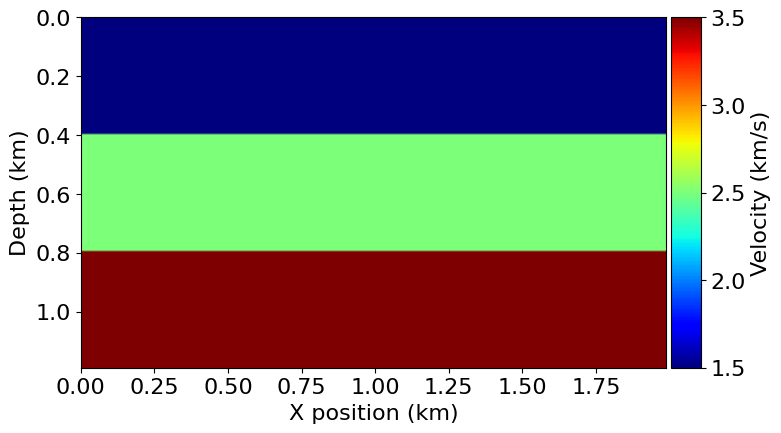

In [69]:
plot_velocity(model)

In [79]:
f0 = 0.020  # peak/dominant frequency

s = model.grid.stepping_dim.spacing
# damp = model.damp

# Time step in ms and time range:
t0, tn = 0., 1800.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

geometry = setup_geometry(model, tn, f0=f0)

In [86]:
# Function that define source and receiver parameters
def source_rec_term(model, u, pos):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = pos[0]  # position of source in offset
    src.coordinates.data[0, -1] = pos[1]  # position of source in depth
    # print('src', src.coordinates.data)

    # Create symbol for receivers
    rec = Receiver(name='rec', grid=model.grid, npoint=shape[0],
                      time_range=time_range)
    # Prescribe even spacing for receivers along the x-axis
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec.coordinates.data[:, 1] = 400.  # postion of receiver at 400 m depth for vx
    
    # src = geometry.src
    # rec = geometry.rec

    # print('rec', rec.coordinates.data)
    s = model.grid.stepping_dim.spacing

    src_term = src.inject(field=u.forward, expr=src * s**2 / model.m)

    rec_term = rec.interpolate(expr=u)

    return rec, rec_term, src_term, src

## Building the forward  operator

The **acoustic_forward(...)** function is responsible for forward modeling and makes use of the second-order acoustic equation described before:

In [72]:
def acoustic_forward(model, pos, geometry, **kwargs):

    u = TimeFunction(name='u', grid=model.grid, save=geometry.nt, time_order=2, space_order=space_order)

    pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))] 

    rec, rec_term, src_term, src = source_rec_term(model, u, pos)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=dt, src=src, rec=rec, vp=model.vp)
    
    return rec, u

In [76]:
# generating a shot with the source in the center of the model

pos = np.zeros((1, 2), dtype=np.float32)
pos[0, 0] = model.domain_size[0] * .5

rec, u = acoustic_forward(model, pos[0], geometry)

src [[995.   0.]]


## Plotting the pressure field shot

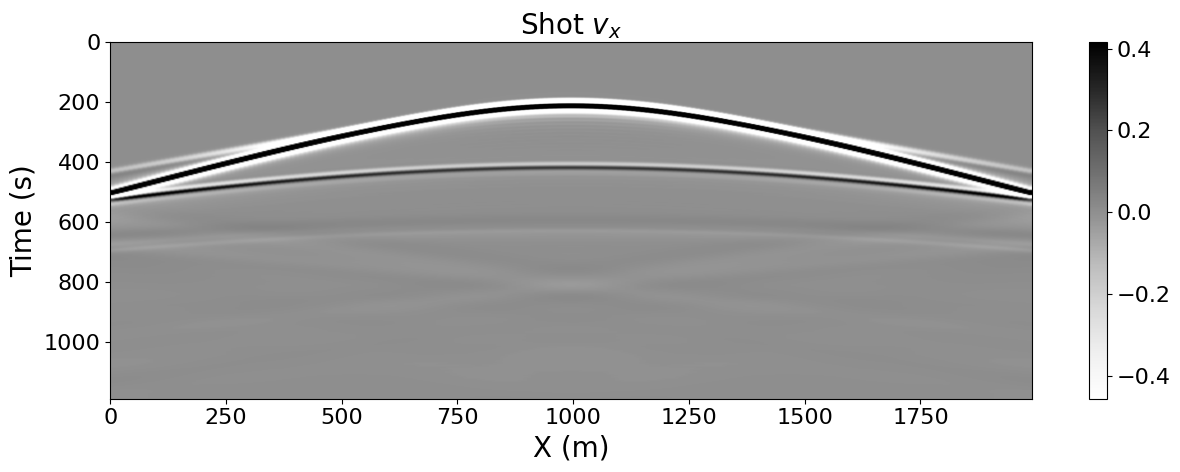

In [77]:
# NBVAL_IGNORE_OUTPUT
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0] +
                                                 model.domain_size[0],
                                                 model.origin[1] +
                                                 model.domain_size[1],
                                                 model.origin[1]]}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))
ax = [ax]
scale = np.max(rec.data) / 10.

img1 = ax[0].imshow(rec.data, vmin=scale, vmax=-scale, **plt_options_model)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title(r"Shot $v_x$", fontsize=20)
ax[0].set_xlabel('X (m)', fontsize=20)
ax[0].set_ylabel('Time (s)', fontsize=20)
ax[0].set_aspect('auto')

plt.tight_layout()

## Plotting the wavefields snapshots

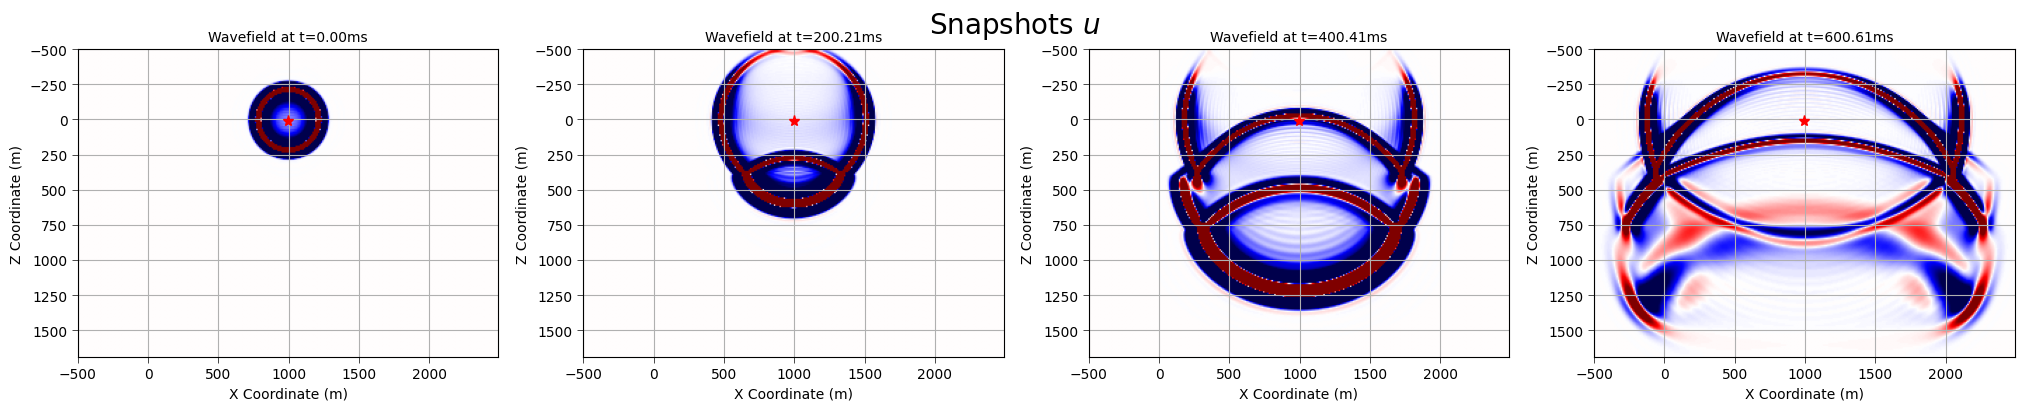

In [81]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad, nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad = np.array(shape) + 2 * nbl
origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot(a, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 9
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=20)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(model.domain_size[0] * .5, 10, 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)


plot(u, title="Snapshots $u$")

# The acoutic adjoint equation

The adjoint operator is constructed from the acoustic wave equation using the adjoint-state method. From the acoustic forward equation

\begin{equation}
     \left\{\begin{array}{l}\rho \dfrac{\partial \vec{v}}{\partial t}-{\bf D} \sigma=0,\\ 
     \dfrac{\partial \sigma}{\partial t}-{\bf C D}^{T} \vec{v}=f_\sigma, \end{array}\right.
\end{equation}

Writing in matrix format:

\begin{equation}
\left[ \begin{array}{cc}\rho \dfrac{\partial}{\partial t} & - {\bf D} \\
    -{\bf C D}^{T} & \dfrac{\partial}{\partial t}\end{array}\right] \left[\begin{array}{l}\vec{v} \\ \sigma\end{array}\right]=\left[\begin{array}{c}0 \\ \vec{f}_\sigma\end{array}\right],
\end{equation}

being

\begin{equation}
{\bf S}=\left [ \begin{array}{cc}\rho \dfrac{\partial}{\partial t} & -{\bf D} \\ -{\bf C D}^{T} & \dfrac{\partial}{\partial t}\end{array}\right],
~W=\left[\begin{array}{l}\vec{v} \\ \sigma\end{array}\right]~\text{and}~
f=\left[\begin{array}{c}0 \\ \vec{f}_\sigma\end{array}\right],
\end{equation}

rewriting as

\begin{equation}
    {\bf SW=f}.
\end{equation}

Solving by the adjoint method, we have the following system:

\begin{equation}
    {\bf S^*W^*=f^*},
\end{equation}

where * denotes the adjoint, the adjoint matrix $S$ becomes $S^*$, $W^*$ is the adjoint state variable vector containing the particle velocity fields $\vec{u}=(u_{x}, u_{z})$ and the adjoint stress tensors ($\tau$). $∆\vec{d} = G(\vec{m}) − \vec{d}$ is the residuals vector which in the context of E-RTM is $∆\vec{d} = −\vec{d} $, where $\vec{d}$ is the observed data,

\begin{equation}
{\bf S}^*= \left[\begin{array}{cc}-\rho \dfrac{\partial}{\partial t} & {\bf D C}^{T} \\ {\bf D}^{T} & -\dfrac{\partial}{\partial t}\end{array}\right],~        
{\bf W}^*=   \left[\begin{array}{c}\vec{u} \\ \tau\end{array}\right]       ~\text{and} ~    
{\bf f}^*= \left[\begin{array}{c}0 \\ \Delta \vec{d}\end{array}\right].
\end{equation}

Thus, matrix system is given by: 

\begin{equation}
    \left[\begin{array}{cc}-\rho \dfrac{\partial}{\partial t} & {\bf D C}^{T} \\ {\bf D}^{T} & -\dfrac{\partial}{\partial t}\end{array}\right] \left[\begin{array}{c}\vec{u} \\ \tau\end{array}\right]=\left[\begin{array}{c}0 \\ \Delta \vec{d}\end{array}\right],
\end{equation}

and, finally we have the compact elastic adjoint equation 

\begin{equation}
    \left\{\begin{array}{l}\rho \dfrac{\partial \vec{u}}{\partial t}-{\bf D C}^{T} \tau=0\\
    {\bf D}^{T} \vec{u}-\dfrac{\partial \tau}{\partial t}=\Delta\overrightarrow{d}\end{array}\right.
\end{equation}

The `elastic_adjoint()` function generates the adjoint equations to be used in the RTM. In this function ${\bf S}$ correspond to ${\bf D}^T$. 

In [82]:
def acoustic_adjoint(model, v):
    pde = model.m * v.dt2 - v.laplace + model.damp * v.dt.T
    # eqn = Eq(v.backward, damp * solve(pde, v.backward))
    eqn = Eq(v.backward, solve(pde, v.backward))

    return eqn


def acoustic_adjoint2(model, rec: PointSource, geometry):
    v = TimeFunction(name='v', grid=model.grid, save=geometry.nt, time_order=2, space_order=space_order)
    eqn = acoustic_adjoint(model, v)
    stencil = [eqn]

    # srca = Receiver(name='srca', grid=model.grid,
    #             time_range=geometry.time_axis,
    #             coordinates=geometry.src_positions)
    srca = geometry.new_src('srca')
    # print('srca', srca.coordinates.data)
    # print('reca', rec.coordinates.data)

    # rec, rec_term, src_term, src = source_rec_term(model, v, pos)
    rec_term = rec.inject(v.backward, rec * s**2 / model.m)
    src_term = srca.interpolate(expr = v)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=dt, rec=rec, vp=model.vp)

    return srca, v

## Imaging condition

We use a source-normalized crosscorrelation imaging conditions for 2D images of the particle-velocity wavefields,
for a common-source gather, which can be formulated mathematically as:

\begin{equation}
I_{xx}(x,z)=\frac{\int^t_0 v_x(x,z,t)u_x(x,z,t)dt}{\int^t_0 v^2_x(x,z,t)dt}
\end{equation}

and

\begin{equation}
I_{zz}(x,z)=\frac{\int^t_0 v_z(x,z,t)u_z(x,z,t)dt}{\int^t_0 v^2_z(x,z,t)dt}
\end{equation}

where $I_{xx}$ and $I_{zz}$ represent the horizontal and vertical image components, respectively.

In [83]:
def ImagingOperator(model, imf, u, **kwargs):

    v = TimeFunction(name='v', grid=model.grid, space_order=space_order,
                           time_order=2)

    eqn = acoustic_adjoint(model, v)

    # Define residual injection at the location of the forward receivers
    rec = PointSource(name='rec', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    H = Function(name="H", grid=model.grid)

    H_sum = [Eq(H, H + (u**2))]

    rec_term = rec.inject(field=v.backward, expr=dt*rec)

    imf_update = [Eq(imf, imf + (u * v)/(H + 10**(-9)))]

    return Operator(eqn + rec_term + H_sum + imf_update, subs=model.spacing_map,
                    name='Imaging')

# Applying the RTM for 10 shots

The `img_final(...)` function is responsible for making the RTM and the sum of the images of each shot, thus generating the final image.

In [84]:
nshots = 10
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.shape[0]*model.spacing[0],
                                     num=nshots)
source_locations[:, 1] = 10.


def img_final(model, geometry):
    imf = Function(name="imf", grid=model.grid, space_order=8)

    for i in range(nshots):
        print('Imaging source %d out of %d' % (i+1, nshots))
        pos = source_locations[i, :]
        rec, u = acoustic_forward(model, pos, geometry)

        op_imaging = ImagingOperator(model, imf, u)
        op_imaging(dt=dt, rec=rec)

    return imf

In [85]:
imf_adj = img_final(model, geometry)

Imaging source 1 out of 10
src [[ 0. 10.]]
Imaging source 2 out of 10
src [[222.22223  10.     ]]
Imaging source 3 out of 10
src [[444.44446  10.     ]]
Imaging source 4 out of 10
src [[666.6667  10.    ]]
Imaging source 5 out of 10
src [[888.8889  10.    ]]
Imaging source 6 out of 10
src [[1111.1111   10.    ]]
Imaging source 7 out of 10
src [[1333.3334   10.    ]]
Imaging source 8 out of 10
src [[1555.5557   10.    ]]
Imaging source 9 out of 10
src [[1777.7778   10.    ]]
Imaging source 10 out of 10
src [[2000.   10.]]


In [87]:
# Plotting for final image
def img(img, model, title=""):

    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

    plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0]
                                                     + model.domain_size[0],
                                                     model.origin[1] +
                                                     model.domain_size[1],
                                                     model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    scale = np.max(img.data[slices])

    img1 = ax.imshow(np.transpose(img.data[slices]), vmin=scale, vmax=-scale,
                        **plt_options_model)
    fig.colorbar(img1, ax=ax)
    ax.set_title(title + "$I$", fontsize=20)
    ax.set_xlabel('z (m)', fontsize=20)
    ax.set_ylabel('x (m)', fontsize=20)
    ax.set_aspect('auto')

    # plt.savefig('Elastic' + title + '.pdf')

In [88]:
def lapla(model, image):
    lapla = Function(name='lapla', grid=model.grid, space_order=8)
    stencil = Eq(lapla, -image.laplace)
    op = Operator([stencil])
    op.apply()
    return lapla

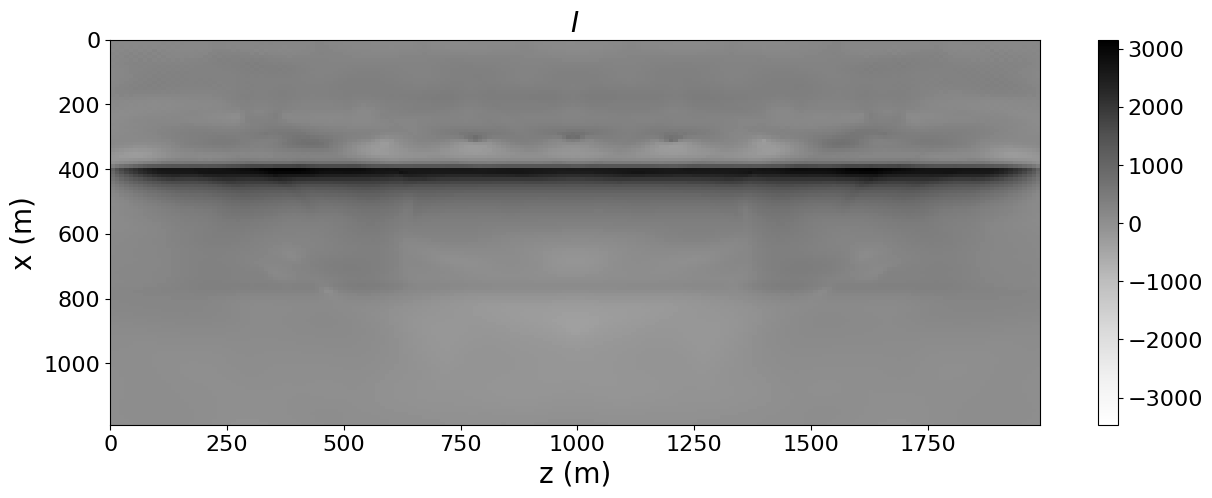

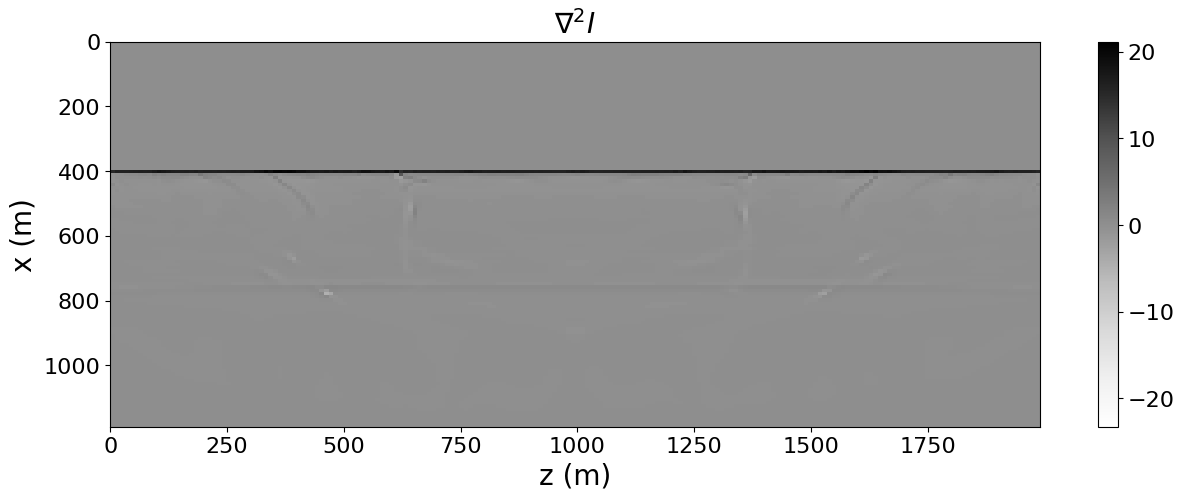

In [89]:
# Applying laplacian filter
image_final_adj = lapla(model, imf_adj)

# Zeroing the water layer

image_final_adj.data[:, :90] = 0.

img(imf_adj, model, title="")
img(image_final_adj, model, title="$\\nabla^2$")

## Adjoint test

The adjoint $A^{*}$ of an operator $A$ has the property:

\begin{equation}
<Ax,~y>=<x,~A^*y>
\end{equation}

where $x$ is the forward wavefield and $y$ is the adjoint wavefield.

In [90]:
from examples.seismic.acoustic.wavesolver import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=space_order)
rec, _, _ = solver.forward()
srca, _, _ = solver.adjoint(rec)
term2 = norm(rec)**2
term1 = np.dot(srca.data.reshape(-1), geometry.src.data)
print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))
assert np.isclose((term1 - term2)/term1, 0., atol=1.e-6)

No source type defined, returning uninitiallized (zero) source
No source type defined, returning uninitiallized (zero) source


<x, A*y>: 50222.957031, <Ax,y>: 50222.968750, difference: -2.3333e-07, ratio: 1.000000


/tmp/ipykernel_33809/1373118712.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'


In [91]:

pos = np.empty((1, 2), dtype=np.float32)
pos[0, 0] = model.domain_size[0] * .5

pos = geometry.src_positions

rec, u = acoustic_forward(model, pos[0], geometry)
norm(rec)**2

np.float32(26483.744)

In [92]:
tn = 500.  # Final time

pos = np.empty((1, 2), dtype=np.float32)
pos[0, 0] = model.domain_size[0] * .5

pos = geometry.src_positions

rec, u = acoustic_forward(model, pos[0], geometry)
srca, v = acoustic_adjoint2(model, rec, geometry)

# Adjoint test: Verify <Ax,y> matches  <x, A^Ty> closely
term1 = np.dot(srca.data.reshape(-1), geometry.src.data)
term2 = norm(rec) ** 2
print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))


assert np.isclose((term1 - term2)/term1, 0., atol=1.e-6)

<x, A*y>: 26483.742188, <Ax,y>: 26483.744141, difference: -7.3748e-08, ratio: 1.000000


/tmp/ipykernel_33809/2315653285.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'


# References

<br>[1] **Time-domain elastic Gauss–Newton full-waveform inversion:
a matrix-free approach** (2020)
<br>Ke Chen and Mauricio D. Sacchi
<br>Geophysical Journal International
<br> https://doi.org/10.1093/gji/ggaa330


<br>[2] **Elastic least-squares reverse time migration** (2017)
<br>Zongcai Feng and Gerard T. Schuster
<br>GEOPHYSICS Technical Papers 
<br>https://doi.org/10.1190/geo2016-0254.1